In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
import scipy.stats
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
from IPython.display import HTML, display
import tabulate

In [4]:
df_z = pd.read_parquet('../data/pre_processed/covid_cases_z_trans.parquet')

# K-means clustering

This notebook performs k-means clustering on the cleaned and z-transformed Covid-19 infection data. The data is accumulated, meaning that if there were 10 new cases day 1 and 2 new cases day 2, number of cases on day 2 would be 12. The dataframe loaded from pre-processing has date as index (01-03-2020 -> 17-03-2020) and country name (string) as column name as shown below.

In [5]:
df_z.head(2)

,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,-1.016766,-0.704723,-1.314497,-2.128248,-1.062776,-0.974537,-1.38328,-2.021154,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828760,-1.206989,-1.733456,-1.337746,-0.739615,-0.683331
2020-03-02,-1.016766,-0.704723,-1.314127,-2.127737,-1.062476,-0.974537,-1.38328,-2.020472,-0.852664,-0.982762,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.828718,-1.206979,-1.733456,-1.337746,-0.739615,-0.683331


The parameters used in this notebook were selected in the notebook parameter_selection -> k_means_parameter_testing by evaluating forecasting accuracies achieved with different hyperparameter combinations (accuracies stored and compared in notebook parameter_selection -> cluster_evaluation_results).

Using sklearn KMeans package to form clusters:

In [6]:
kmeans_z = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=100, algorithm='auto').fit(df_z.T)

Array matching each country to its assigned cluster:

In [7]:
labels_kmeans_z = kmeans_z.labels_[:]
labels_kmeans_z

array([2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 3, 1, 2, 2, 0, 1, 0, 3, 2, 2, 3, 2,
       3, 3, 1, 0, 0, 3, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 0, 2, 0,
       2, 0, 2, 3, 1, 3, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 1, 3, 3, 1, 0, 3, 2, 1, 3, 1, 1, 2, 2, 2], dtype=int32)

Distribution of countries between clusters:

In [8]:
print("Countries in cluster 0:", np.count_nonzero(labels_kmeans_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_kmeans_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_kmeans_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_kmeans_z == 3))

Countries in cluster 0: 12
Countries in cluster 1: 24
Countries in cluster 2: 30
Countries in cluster 3: 17


Creating a new dataframe for each cluster. The new formed dataframes have same format as df_z, however only the respective countries present in each cluster are included in each new dataframe. 

In [9]:
df_kmeans_z_0 = df_z.T.loc[labels_kmeans_z== 0].transpose()
df_kmeans_z_1 = df_z.T.loc[labels_kmeans_z == 1].transpose()
df_kmeans_z_2 = df_z.T.loc[labels_kmeans_z == 2].transpose()
df_kmeans_z_3 = df_z.T.loc[labels_kmeans_z == 3].transpose()

Plotting the created clusters:

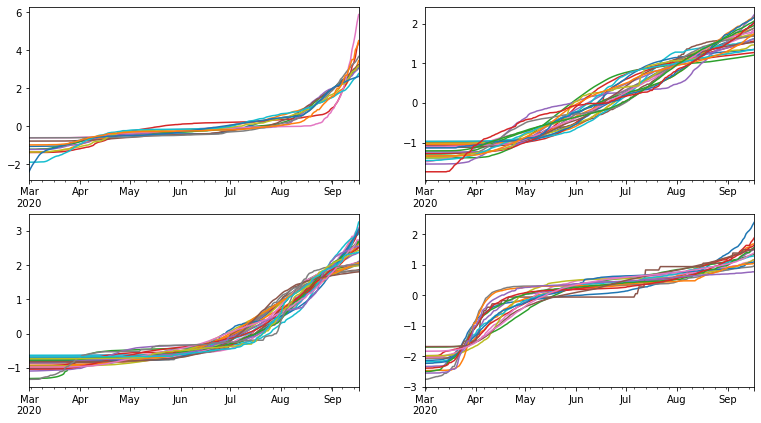

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
df_kmeans_z_2.plot(legend='', ax=axes[1,0])
df_kmeans_z_3.plot(legend='', ax=axes[1,1])

### Cluster score

Scoring the clusters was originally planned to be based on three chosen metrics, being Silhouette Score, Davies-Bouldin and Calinski-Harabasz scores.
Short summarized: it is desirable to achieve a high Silhouette score, low Davies Bouldin score and a high Calinski Harabasz score.

The Silhouette score consists of two scores, namely the mean distance between a sample and all other points in the same class (cohesion), a, and the mean distance between a sample and all other points in the next nearest cluster (separation), b \citep{choosek}. The score is given by using a and b in the following formula: 
   
   Silhouette score = (b-a)/max(a, b).
   
The score is a number between -1 and 1, where 1 is the optimal score indicating a highly dense clustering. The number -1 indicates incorrect clustering, while a score around zero indicates overlapping clusters. The advantage of such a score is bounded between the interval [-1, 1], and also that the score is relating to a standard concept of a cluster, namely that a higher, meaning better, score indicates dense and well separated clusters. However, the score has a high computational time. 



Source: 

Scikit-learn. (2020). 2.3 Clustering. Retrieved from: https://scikit-learn.org/stable/modules/clustering.html

Scikit-learn. (2020). sklearn.metrics.silhouettescore. Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score


The Davies-Bouldin score is a score that indicates the similarity between clusters. Similarity in this score is a measure that compares the distance between clusters with the size of the cluster itself. The closer the score is to zero the better. The advantages of such a score is that it is simpler to compute than the Silhouette scores. However, one of its disadvantages is that the usage of centroid distance limits the distance metric to Euclidean space.



Source:

Scikit-learn. (2020). 2.3 Clustering. Retrieved from: https://scikit-learn.org/stable/modules/clustering.html

Scikit-learn. (2020). sklearn.metrics.daviesbouldinscore. Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score

The Calinski-Harabasz score, also known as the Variance Ratio Criterion, is a score used to evaluate models based on the ratio of the sum of between-cluster dispersion and of inter-cluster dispersion for all clusters. Dispersion is defined as the sum of distances squared. A higher score relates to a model having better defined clusters. The advantage of such a score is that it is higher when clusters are dense and well separated. Moreover, this score is fast to compute. 


Source: 

Scikit-learn. (2020). 2.3 Clustering. Retrieved from: https://scikit-learn.org/stable/modules/clustering.html

Scikit-learn. (2020). sklearn.metrics.calinskiharabaszscore. Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score

In [11]:
table = [["Method", "Score"],
        ["Silhouette score",round(silhouette_score(df_z.T, labels=labels_kmeans_z, metric='euclidean'),4)],
        ["Davies Bouldin score",round(davies_bouldin_score(df_z.T, labels=labels_kmeans_z),4)],
        ["Calinski Harabasz score",round(calinski_harabasz_score(df_z.T, labels=labels_kmeans_z),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Method,Score
Silhouette score,0.354
Davies Bouldin score,0.9912
Calinski Harabasz score,67.4395


#### Exporting clustering results

Cluster results are saved in parquet file. Later used in forecasting notebook forecasting -> forecasting_w_catboost_clusters

In [12]:
#df_kmeans_z_0.to_parquet('../results/clustering_results/df_kmeans_z_0.parquet')
#df_kmeans_z_1.to_parquet('../results/clustering_results/df_kmeans_z_1.parquet')
#df_kmeans_z_2.to_parquet('../results/clustering_results/df_kmeans_z_2.parquet')
#df_kmeans_z_3.to_parquet('../results/clustering_results/df_kmeans_z_3.parquet')